In [1]:
import pandas as pd
import geopandas as gpd

from oggm import cfg, utils, workflow
from oggm.core import flowline, gis, climate
import oggm_vas as vascaling

rgi_region = '11'
rgi_version = '61'
reset = False

# load default parameter file
cfg.initialize()

# set necessary paths and parameters
wdir = '/Users/oberrauch/work/master/working_directories/histalp'
utils.mkdir(wdir, reset=reset)

cfg.PATHS['working_dir'] = wdir
cfg.PARAMS['rgi_version'] = rgi_version
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
# get RGI dataframe and initialize gdirs

2020-09-13 15:09:31: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-09-13 15:09:31: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-09-13 15:09:31: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-09-13 15:09:32: oggm.utils: Checking the download verification file checksum...
2020-09-13 15:09:45: oggm.utils: Failed getting verification checksum: ConnectionError(MaxRetryError("HTTPSConnectionPool(host='cluster.klima.uni-bremen.de', port=443): Max retries exceeded with url: /data/downloads.sha256.hdf.sha256 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x13f8ee080>: Failed to establish a new connection: [Errno 60] Operation timed out',))",),)
2020-09-13 15:09:45: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-09-13 15:09:45: oggm.cfg: PARAMS['prcp_scaling_factor'] changed from `2.5` to `1.75`.
2020-09-13 15:09:45: oggm.cfg: PARAMS['temp_melt

In [1]:
import pandas as pd
import geopandas as gpd

from oggm import cfg, utils, workflow
from oggm.core import flowline, gis, climate
import oggm_vas as vascaling

rgi_region = '11'
rgi_version = '6'
reset = False

# load default parameter file
cfg.initialize()

# set necessary paths and parameters
wdir = '/Users/oberrauch/work/master/working_directories/histalp'
utils.mkdir(wdir, reset=reset)

cfg.PATHS['working_dir'] = wdir
cfg.PARAMS['rgi_version'] = rgi_version
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
# get RGI dataframe and initialize gdirs
rgi_fpath = utils.get_rgi_region_file(rgi_region, rgi_version, reset=reset)
rgidf = gpd.read_file(rgi_fpath)

2020-08-12 11:00:14: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-08-12 11:00:14: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-08-12 11:00:14: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-08-12 11:00:14: oggm.utils: Checking the download verification file checksum...
2020-08-12 11:00:15: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-08-12 11:00:15: oggm.cfg: PARAMS['prcp_scaling_factor'] changed from `2.5` to `1.75`.
2020-08-12 11:00:15: oggm.cfg: PARAMS['temp_melt'] changed from `-1.0` to `-1.75`.
2020-08-12 11:00:15: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


In [3]:
# get RGI dataframe and initialize gdirs
rgi_fpath = utils.get_rgi_region_file(rgi_region, version='6', reset=False)
rgidf = gpd.read_file(rgi_fpath)
rgi_ids = [rgi_id for rgi_id in rgidf[rgidf.O2Region == '1'].RGIId]

In [6]:
from oggm.shop import histalp
import xarray as xr

In [7]:
hist_temp_fpath = histalp.get_histalp_file(var='tmp')
hist_prcp_fpath = histalp.get_histalp_file(var='pre')

2020-09-13 15:12:44: oggm.utils: No known hash for www.zamg.ac.at/histalp/download/grid5m/HISTALP_temperature_1780-2014.nc.bz2
2020-09-13 15:12:44: oggm.utils: No known hash for www.zamg.ac.at/histalp/download/grid5m/HISTALP_precipitation_all_abs_1801-2014.nc.bz2


In [8]:
hist_temp = xr.open_dataset(hist_temp_fpath, decode_times=False)
hist_prcp = xr.open_dataset(hist_prcp_fpath, decode_times=False)

In [9]:
def get_min_max(data_array):
    return [float(data_array.min().values), float(data_array.max().values)]

In [10]:
lon_temp = get_min_max(hist_temp.lon)
lat_temp = get_min_max(hist_temp.lat)

In [11]:
lon_prcp = get_min_max(hist_prcp.lon)
lat_prcp = get_min_max(hist_prcp.lat)

In [12]:
print(lon_temp)
print(lon_prcp)

[4.08333333333335, 18.91666666666075]
[4.08333333333335, 18.91666666666075]


In [13]:
print(lat_temp)
print(lat_prcp)

[43.08333333333335, 48.91666666666435]
[43.08333333333335, 48.91666666666435]


In [14]:
histalp_lat_lim = (43.08333333333335, 48.91666666666435)
histalp_lon_lim = (4.08333333333335, 18.91666666666075)

In [15]:
((rgidf.CenLon >= histalp_lon_lim[0]) & (rgidf.CenLon <= histalp_lon_lim[1])).all()

False

In [16]:
((rgidf.CenLat >= histalp_lat_lim[0]) & (rgidf.CenLat <= histalp_lat_lim[1])).all()

False

In [70]:
rgidf[(rgidf.CenLon < histalp_lon_lim[0]) | (rgidf.CenLon > histalp_lon_lim[1])]

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
3203,RGI60-11.03204,G001089E42799N,20111001,-9999999,1.088501,42.798626,11,2,0.021,2383,...,325,0,0,0,0,9,9,Valier,None,"POLYGON ((1.08814 42.79820, 1.08813 42.79821, ..."
3204,RGI60-11.03205,G000666E42627N,20111001,-9999999,0.666092,42.626839,11,2,0.077,2925,...,257,0,0,0,0,9,9,Tempestades,None,"POLYGON ((0.66445 42.62729, 0.66447 42.62723, ..."
3205,RGI60-11.03206,G000659E42632N,20111001,-9999999,0.658785,42.632011,11,2,0.067,3046,...,305,0,0,0,0,9,9,Barrancs,None,"POLYGON ((0.65923 42.63315, 0.65948 42.63311, ..."
3206,RGI60-11.03207,G000654E42633N,20111001,-9999999,0.654112,42.632977,11,2,0.015,3176,...,141,0,0,0,0,9,9,Coronas,None,"POLYGON ((0.65393 42.63148, 0.65384 42.63148, ..."
3207,RGI60-11.03208,G000646E42641N,20111001,-9999999,0.646032,42.641357,11,2,0.622,2955,...,720,0,0,0,0,9,9,Aneto,None,"POLYGON ((0.64693 42.64412, 0.64708 42.64403, ..."
3208,RGI60-11.03209,G000639E42649N,20111001,-9999999,0.639343,42.648979,11,2,0.260,2899,...,709,0,0,0,0,9,1,Maladeta E,None,"POLYGON ((0.63989 42.65335, 0.64000 42.65315, ..."
3209,RGI60-11.03210,G000633E42652N,20111001,-9999999,0.632566,42.652107,11,2,0.054,2984,...,309,0,0,0,0,9,9,Maladeta W,None,"POLYGON ((0.63353 42.65282, 0.63353 42.65261, ..."
3210,RGI60-11.03211,G000555E42700N,20111001,-9999999,0.555278,42.700157,11,2,0.050,2727,...,215,0,0,0,0,9,9,Boum,None,"POLYGON ((0.55964 42.70112, 0.55968 42.70105, ..."
3211,RGI60-11.03212,G000511E42693N,20111001,-9999999,0.511460,42.693188,11,2,0.040,2794,...,257,0,0,0,0,9,9,Portillon d Oo,None,"POLYGON ((0.51204 42.69227, 0.51188 42.69225, ..."
3212,RGI60-11.03213,G000494E42694N,20111001,-9999999,0.494304,42.694481,11,2,0.105,2822,...,404,0,0,0,0,9,9,Seil de la Baque E,None,"POLYGON ((0.49771 42.69364, 0.49782 42.69360, ..."


In [71]:
rgidf[(rgidf.CenLat < histalp_lat_lim[0]) | (rgidf.CenLat > histalp_lat_lim[1])]

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
3203,RGI60-11.03204,G001089E42799N,20111001,-9999999,1.088501,42.798626,11,2,0.021,2383,...,325,0,0,0,0,9,9,Valier,None,"POLYGON ((1.08814 42.79820, 1.08813 42.79821, ..."
3204,RGI60-11.03205,G000666E42627N,20111001,-9999999,0.666092,42.626839,11,2,0.077,2925,...,257,0,0,0,0,9,9,Tempestades,None,"POLYGON ((0.66445 42.62729, 0.66447 42.62723, ..."
3205,RGI60-11.03206,G000659E42632N,20111001,-9999999,0.658785,42.632011,11,2,0.067,3046,...,305,0,0,0,0,9,9,Barrancs,None,"POLYGON ((0.65923 42.63315, 0.65948 42.63311, ..."
3206,RGI60-11.03207,G000654E42633N,20111001,-9999999,0.654112,42.632977,11,2,0.015,3176,...,141,0,0,0,0,9,9,Coronas,None,"POLYGON ((0.65393 42.63148, 0.65384 42.63148, ..."
3207,RGI60-11.03208,G000646E42641N,20111001,-9999999,0.646032,42.641357,11,2,0.622,2955,...,720,0,0,0,0,9,9,Aneto,None,"POLYGON ((0.64693 42.64412, 0.64708 42.64403, ..."
3208,RGI60-11.03209,G000639E42649N,20111001,-9999999,0.639343,42.648979,11,2,0.260,2899,...,709,0,0,0,0,9,1,Maladeta E,None,"POLYGON ((0.63989 42.65335, 0.64000 42.65315, ..."
3209,RGI60-11.03210,G000633E42652N,20111001,-9999999,0.632566,42.652107,11,2,0.054,2984,...,309,0,0,0,0,9,9,Maladeta W,None,"POLYGON ((0.63353 42.65282, 0.63353 42.65261, ..."
3210,RGI60-11.03211,G000555E42700N,20111001,-9999999,0.555278,42.700157,11,2,0.050,2727,...,215,0,0,0,0,9,9,Boum,None,"POLYGON ((0.55964 42.70112, 0.55968 42.70105, ..."
3211,RGI60-11.03212,G000511E42693N,20111001,-9999999,0.511460,42.693188,11,2,0.040,2794,...,257,0,0,0,0,9,9,Portillon d Oo,None,"POLYGON ((0.51204 42.69227, 0.51188 42.69225, ..."
3212,RGI60-11.03213,G000494E42694N,20111001,-9999999,0.494304,42.694481,11,2,0.105,2822,...,404,0,0,0,0,9,9,Seil de la Baque E,None,"POLYGON ((0.49771 42.69364, 0.49782 42.69360, ..."


In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
import numpy as np
np.repeat(histalp_lon_lim, 2)

array([ 4.08333333,  4.08333333, 18.91666667, 18.91666667])

In [85]:
np.tile(histalp_lat_lim, 2)

array([43.08333333, 48.91666667, 43.08333333, 48.91666667])

In [96]:
XX

array([[ 4.08333333, 18.91666667],
       [ 4.08333333, 18.91666667]])

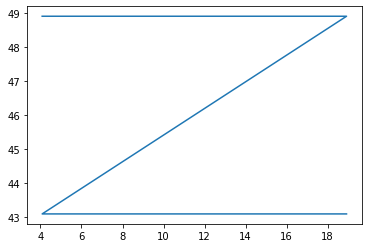

In [99]:
XX, YY = np.meshgrid(histalp_lon_lim, histalp_lat_lim)


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

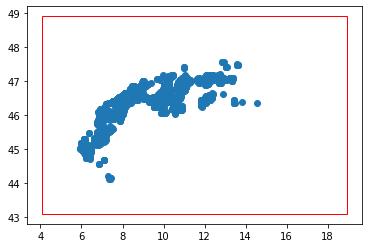

In [22]:
rgi_hist = rgidf[rgidf.O2Region == '1'].copy(deep=True)
plt.plot(rgi_hist.CenLon, rgi_hist.CenLat, ls='None', marker='o')
plt.gca().add_patch(Rectangle((histalp_lon_lim[0],histalp_lat_lim[0]),
                              np.diff(histalp_lon_lim)[0], np.diff(histalp_lat_lim)[0],
                              facecolor='None', edgecolor='r'))

In [24]:
# get RGI dataframe and initialize gdirs
rgi_fpath = utils.get_rgi_region_file(rgi_region, '6', reset=reset)
rgidf = gpd.read_file(rgi_fpath)
rgi_ids = [rgi_id for rgi_id in rgidf[rgidf.O2Region == '1'].RGIId]

In [33]:
pd.DataFrame(rgi_ids, columns=['RGIId']).to_csv('../data/histalp_rgi_ids.csv')

In [37]:
pd.read_csv('../data/histalp_rgi_ids.csv', index_col=0)['RGIId'].values

array(['RGI60-11.00001', 'RGI60-11.00002', 'RGI60-11.00003', ...,
       'RGI60-11.03925', 'RGI60-11.03926', 'RGI60-11.03927'], dtype=object)

In [40]:
float(hist_temp.lon.min().values)

4.08333333333335

In [ ]:
histalp.get_histalp_file(var='pre')

In [1]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

# import the needed OGGM modules
from oggm import cfg, utils, workflow, graphics
from oggm.core import gis, climate, flowline

In [2]:
ds = xr.open_dataset('/Users/oberrauch/work/master/data/eq_runs/eq_rofental.nc')
ds

<xarray.Dataset>
Dimensions:         (mb_model: 2, model: 2, normalized: 2, rgi_id: 6, temp_bias: 3, time: 10001)
Coordinates:
  * model           (model) object 'vas' 'fl'
  * temp_bias       (temp_bias) float64 0.0 0.5 -0.5
  * normalized      (normalized) int64 0 1
  * rgi_id          (rgi_id) object 'RGI60-11.00719' 'RGI60-11.00897' ... 'sum'
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 9.998e+03 9.999e+03 1e+04
    hydro_year      (mb_model, time) float64 ...
    hydro_month     (mb_model, time) float64 ...
  * mb_model        (mb_model) object 'constant' 'random'
    calendar_year   (mb_model, time) float64 ...
    calendar_month  (mb_model, time) float64 ...
Data variables:
    volume          (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
    area            (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
    length          (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
    ela             (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.1.2.dev44+gf9ab669
    calendar:       365-day no leap
    creation_date:  2020-08-10 14:41:17

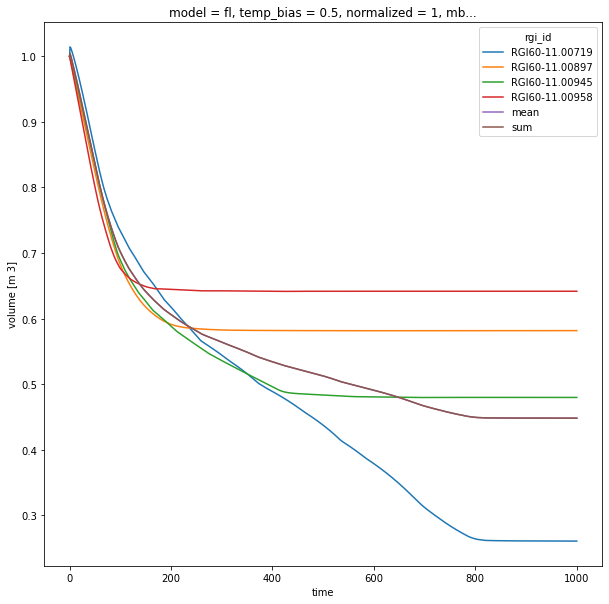

In [12]:
ds.volume.sel(normalized=int(True), temp_bias=.5, mb_model='constant', model='fl').plot.line(x='time', hue='rgi_id', figsize=[10,10])

(0.0, 1000.0)

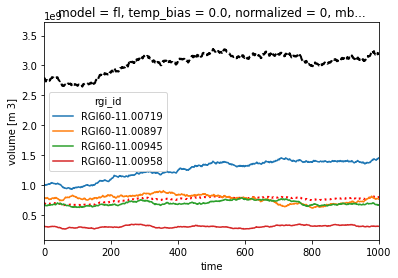

In [36]:
normalized = int(False)
ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=normalized,
                                                            temp_bias=0,
                                                            mb_model='random', 
                                                            model='fl').volume.sum(dim='rgi_id').plot(c='k', ls='--', lw=2)

ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=normalized,
                                                            temp_bias=0,
                                                            mb_model='random', 
                                                            model='fl').volume.mean(dim='rgi_id').plot(c='r', ls=':', lw=2)

ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=normalized,
                                                            temp_bias=0,
                                                            mb_model='random', 
                                                            model='fl').volume.plot.line(hue='rgi_id')
plt.xlim(0,1e3)

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


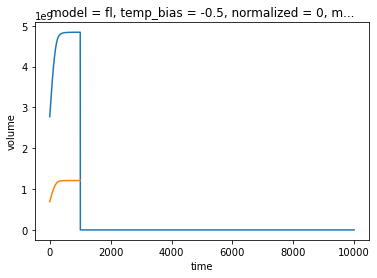

In [26]:
ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=int(False), temp_bias=-0.5, mb_model='constant', model='fl').volume.sum(dim='rgi_id').plot()
ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=int(False), temp_bias=-0.5, mb_model='constant', model='fl').volume.mean(dim='rgi_id').plot()

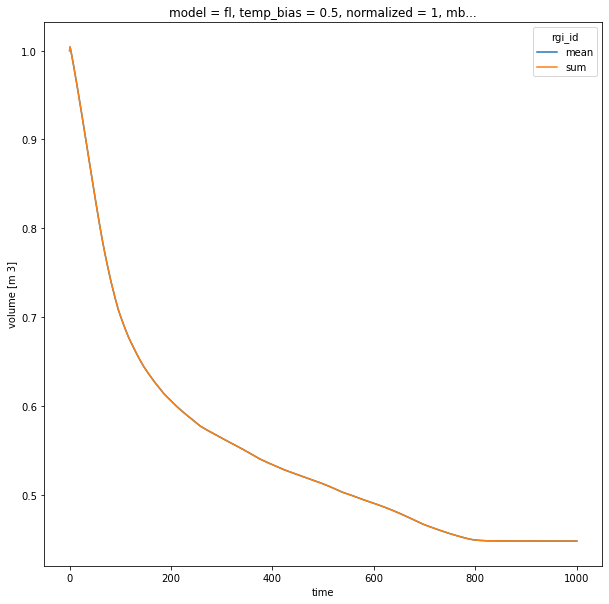

In [17]:
ds.volume.sel(rgi_id=['mean', 'sum'], normalized=int(True), temp_bias=.5, mb_model='constant', model='fl').plot.line(x='time', hue='rgi_id', figsize=[10,10])

In [2]:
import oggm_vas as vascaling

In [3]:
cfg.initialize()

2020-08-10 14:54:49: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-08-10 14:54:49: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-08-10 14:54:49: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-08-10 14:54:49: oggm.utils: Checking the download verification file checksum...


In [42]:
cfg.PATHS['working_dir'] = '/Users/oberrauch/tmp/OGGM/_tmp'

In [45]:
rgi_ids = ['RGI60-11.00719']
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

In [46]:
gdirs = workflow.init_glacier_directories(rgidf)

2020-08-10 14:32:30: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **

In [54]:
utils.compile_run_output(gdirs, input_filesuffix='_bias_zero')

2020-08-10 14:34:33: oggm.utils: Applying compile_run_output on 1 gdirs.


<xarray.Dataset>
Dimensions:         (rgi_id: 1, time: 1001)
Coordinates:
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 997.0 998.0 999.0 1e+03
  * rgi_id          (rgi_id) <U14 'RGI60-11.00719'
    hydro_year      (time) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999 1000
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    calendar_year   (time) int64 -1 0 1 2 3 4 5 ... 993 994 995 996 997 998 999
    calendar_month  (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
Data variables:
    volume          (time, rgi_id) float64 1.028e+09 1.044e+09 ... 1.492e+09
    area            (time, rgi_id) float64 8.559e+06 8.551e+06 ... 9.906e+06
    length          (time, rgi_id) float64 6.834e+03 6.936e+03 ... 8.466e+03
    ela             (time, rgi_id) float64 3.177e+03 3.025e+03 ... 3.319e+03
Attributes:
    description:    OGGM model output
    oggm_version:   1.1.2.dev44+gf9ab669
    calendar:       365-day no leap
    creation_date:  2020-08-10 12:34:33

In [5]:
wdir = utils.gettempdir('_tmp', home=True)
wdir

'/Users/oberrauch/tmp/OGGM/_tmp'

In [38]:
ls /Users/oberrauch/tmp/OGGM/_tmp

log/                     run_output_bias_p.nc
per_glacier/             run_output_bias_zero.nc


In [7]:
ds = xr.open_dataset(os.path.join(wdir, 'run_output_bias_p.nc'))
ds

<xarray.Dataset>
Dimensions:         (rgi_id: 54, time: 1001)
Coordinates:
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 997.0 998.0 999.0 1e+03
  * rgi_id          (rgi_id) object 'RGI60-11.00674' ... 'RGI60-11.01040'
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Data variables:
    volume          (time, rgi_id) float32 ...
    area            (time, rgi_id) float32 ...
    length          (time, rgi_id) float32 ...
    ela             (time, rgi_id) float32 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.1.2.dev44+gf9ab669
    calendar:       365-day no leap
    creation_date:  2020-08-10 11:52:01

In [12]:
tmp = ds.mean(dim='rgi_id')
tmp.coords['rgi_id'] = 'mean'

sum_ = ds.mean(dim='rgi_id')
sum_.coords['rgi_id'] = 'sum'

In [ ]:
# compute average over all glaciers
ds_mean_normal = normalize_ds_with_start(ds).mean(dim='rgi_id')
ds_mean = ds.mean(dim='rgi_id')
    
# compute sum over all glaciers
ds_sum_normal = normalize_ds_with_start(ds.sum(dim='rgi_id'))
ds_sum = ds.sum(dim='rgi_id')

In [10]:
def normalize_ds_with_start(ds, store_var_0=False):
    """ Normalize all data variables of the given xarray Dataset
    with their respective first entry. Returns a new xarray.Dataset.

    Parameters
    ----------
    ds: :py:class:`xarray.Dataset`

    Returns
    -------
    Normalized xarray Dataset

    """
    # copy dataset
    ds_norm = ds.copy(deep=True)

    # iterate over all data variables
    for var in ds_norm:
        # add information about the initial values
        var_0 = ds_norm[var].isel(time=0)
        if store_var_0:
            ds_norm[var + '_0'] = var_0
        # normalize dataset
        ds_norm[var] /= var_0

    return ds_norm

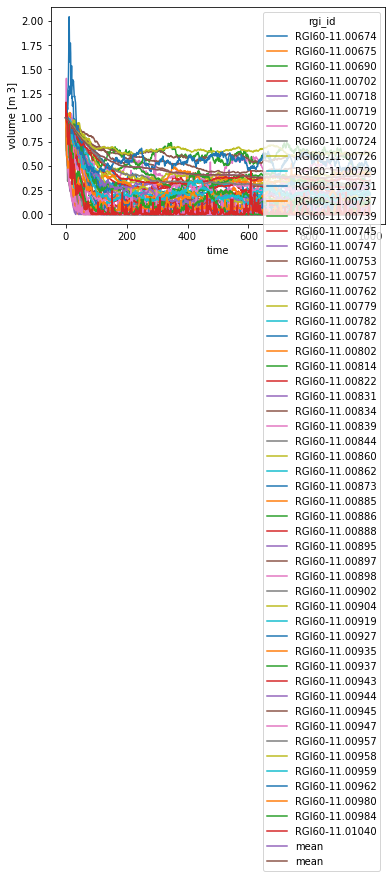

In [11]:
ds_norm = normalize_ds_with_start(xr.concat([ds, tmp, sum_], dim='rgi_id'))
ds_norm.volume.plot.line(x='time')

In [99]:
%matplotlib inline

In [57]:
use_random_mb = False
temp_bias = -0.5
'test_{}_{}_{:+.1f}.nc'.format('fl', 'random' if use_random_mb else 'constant',temp_bias)

'test_fl_constant_-0.5.nc'

In [100]:
ds = xr.open_dataset(os.path.join(wdir, 'run_output_bias_zero.nc'))
ds.volume.sum(dim='rgi_id').plot.line(x='time', add_legend=False, figsize=[10, 10]);

In [103]:
plt.plot(np.random(10))

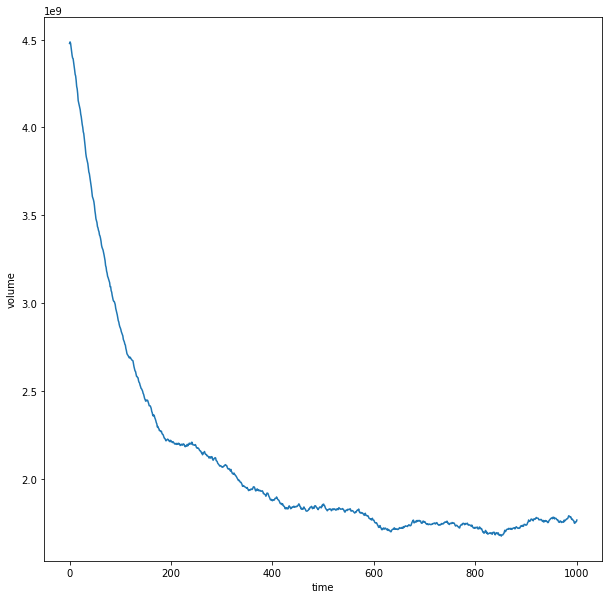

In [36]:
ds = xr.open_dataset(os.path.join(wdir, 'run_output_bias_p.nc'))
a

In [4]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgi_ids = [rgi_id for rgi_id in rgidf.RGIId]

rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
rgi_version = (rgi_ids[0].split('-')[0])[-2:]

# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_wdir'
if not os.path.exists(wdir):
    os.makedirs(wdir)
# shutil.rmtree(wdir)
# os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False

# read RGI entry for the glaciers as DataFrame
# containing the outline area as shapefile
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

# sort by area for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

# initialize the GlacierDirectory
gdirs = workflow.init_glacier_directories(rgidf)

2020-08-10 11:30:18: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-08-10 11:30:18: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-08-10 11:30:18: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-08-10 11:30:18: oggm.cfg: PARAMS['rgi_version'] changed from `61` to `60`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['border'] changed from `20` to `120`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['prcp_scaling_factor'] changed from `2.5` to `1.75`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['temp_melt'] changed from `-1.0` to `-1.75`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['use_bias_for_run'] changed from `True` to `False`.
2020-08-10 11:30:19: oggm.workflow: Execute entity task GlacierDirectory on 54 glaciers


RuntimeError: b'no arguments in initialization list'

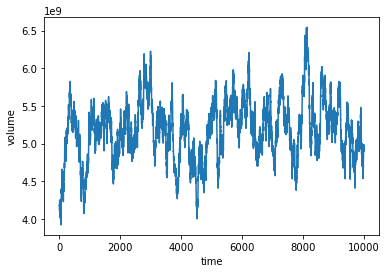

In [11]:
utils.compile_run_output(gdirs, filesuffix='_normal').volume.sum(dim='rgi_id').plot()

In [12]:
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_wdir'

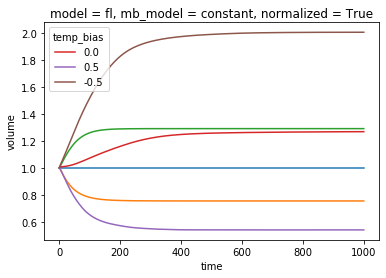

In [19]:
mb_model = 'constant'
model = 'vas'
ds = xr.open_dataset(os.path.join(wdir, 'run_output_{}_{}.nc'.format(mb_model, model)))
ds.sel(normalized=True).volume.plot.line(x='time')
ax = plt.gca()
mb_model = 'constant'
model = 'fl'
ds = xr.open_dataset(os.path.join(wdir, 'run_output_{}_{}.nc'.format(mb_model, model)))
ds.sel(normalized=True).volume.plot.line(x='time', ax=ax)

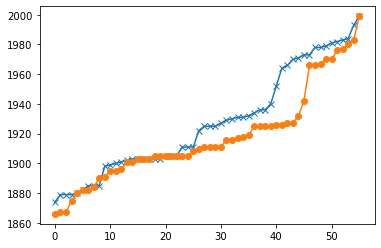

In [109]:
ref_df_oggm = pd.read_csv(utils.get_demo_file('oggm_ref_tstars_rgi6_histalp.csv'), index_col=0)
ref_df_vas = pd.read_csv(utils.get_demo_file('vas_ref_tstars_rgi6_histalp.csv'), index_col=0)
tstars_oggm = ref_df_oggm.tstar.values
tstars_vas = ref_df_vas.tstar.values
plt.plot(np.sort(tstars_oggm), marker='x')
plt.plot(np.sort(tstars_vas), marker='o')

56

In [110]:
ref_df_vas

,lon,lat,n_mb_years,tstar,bias
RGI60-11.00002,13.613500,47.484500,8,1911,25.030687
RGI60-11.00012,13.058100,47.424200,10,1967,1.894659
RGI60-11.00073,12.595600,47.140300,17,1983,6.710049
RGI60-11.00080,12.596400,47.131600,63,1932,2.570614
RGI60-11.00106,12.696700,47.099100,28,1890,-12.909590
RGI60-11.00190,12.378400,47.085100,8,1867,1.599925
RGI60-11.00251,12.947200,47.053000,16,1980,14.303069
RGI60-11.00289,12.970200,47.042100,26,1882,-0.175383
RGI60-11.00300,13.004900,47.038500,32,1917,0.670287
RGI60-11.00603,11.224700,46.965600,19,1911,382.336042


In [111]:
ref_df_oggm.tstar-ref_df_vas.tstar

RGI60-11.00002    -13
RGI60-11.00012    -33
RGI60-11.00073     -5
RGI60-11.00080      4
RGI60-11.00106    -10
RGI60-11.00190    117
RGI60-11.00251      3
RGI60-11.00289     89
RGI60-11.00300    -18
RGI60-11.00603      0
RGI60-11.00619    -16
RGI60-11.00638      0
RGI60-11.00647     99
RGI60-11.00719     98
RGI60-11.00781      0
RGI60-11.00787     39
RGI60-11.00797     15
RGI60-11.00804    -25
RGI60-11.00807      0
RGI60-11.00843     89
RGI60-11.00892    -24
RGI60-11.00897     22
RGI60-11.00918      0
RGI60-11.00929    -34
RGI60-11.01238      0
RGI60-11.01450    -63
RGI60-11.01662    -17
RGI60-11.01704    -21
RGI60-11.01776    -20
RGI60-11.01834     -2
RGI60-11.01876     -1
RGI60-11.01930    -21
RGI60-11.01987    -44
RGI60-11.02072    -59
RGI60-11.02214      0
RGI60-11.02245     12
RGI60-11.02249      0
RGI60-11.02285      0
RGI60-11.02648      0
RGI60-11.02671     11
RGI60-11.02679      5
RGI60-11.02704     58
RGI60-11.02746     12
RGI60-11.02764     70
RGI60-11.02766      6
RGI60-11.0

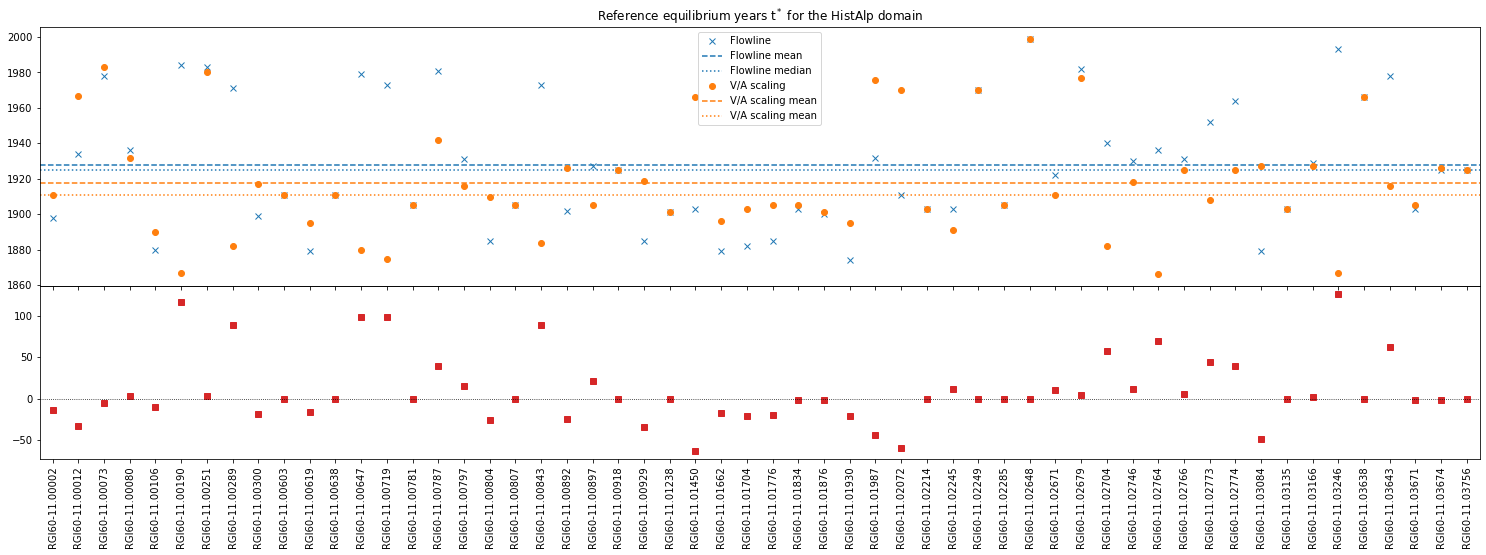

In [116]:
fig = plt.figure(figsize=[20,6])

ax = fig.add_axes([0,0,1,0.4])
ax.plot(ref_df_oggm.tstar-ref_df_vas.tstar, c='tab:red', ls='', marker='s')
ax.axhline(0, ls=':', lw=0.8, c='k')
ax.set_xlim([-0.5,len(ref_df_oggm)-0.5])
plt.xticks(rotation=90);

ax = fig.add_axes([0,0.4,1,0.6])
ax.plot(ref_df_oggm.tstar, ls='', marker='x', label='Flowline', c='tab:blue')
ax.axhline(ref_df_oggm.tstar.mean(), ls='--', c='tab:blue', label='Flowline mean')
ax.axhline(ref_df_oggm.tstar.median(), ls=':', c='tab:blue', label='Flowline median')

ax.plot(ref_df_vas.tstar, ls='', marker='o', label='V/A scaling', c='tab:orange')
ax.axhline(ref_df_vas.tstar.mean(), ls='--', c='tab:orange', label='V/A scaling mean')
ax.axhline(ref_df_vas.tstar.median(), ls=':', c='tab:orange', label='V/A scaling mean')

ax.set_xticklabels([])
plt.xlim([-0.5,len(ref_df_oggm)-0.5])
plt.title('Reference equilibrium years t$^*$ for the HistAlp domain')
plt.legend(title='')

{'whiskers': [<matplotlib.lines.Line2D at 0x12b885ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x12b885358>,
 'boxes': [<matplotlib.lines.Line2D at 0x12b885c88>,
 'medians': [<matplotlib.lines.Line2D at 0x12b87e780>,
 'fliers': [<matplotlib.lines.Line2D at 0x12b87e940>,
 'means': []}

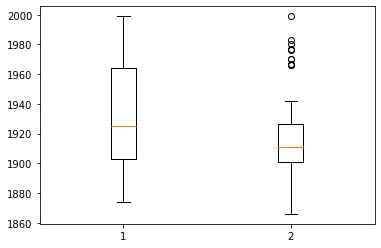

In [119]:
plt.boxplot([ref_df_oggm.tstar, ref_df_vas.tstar])

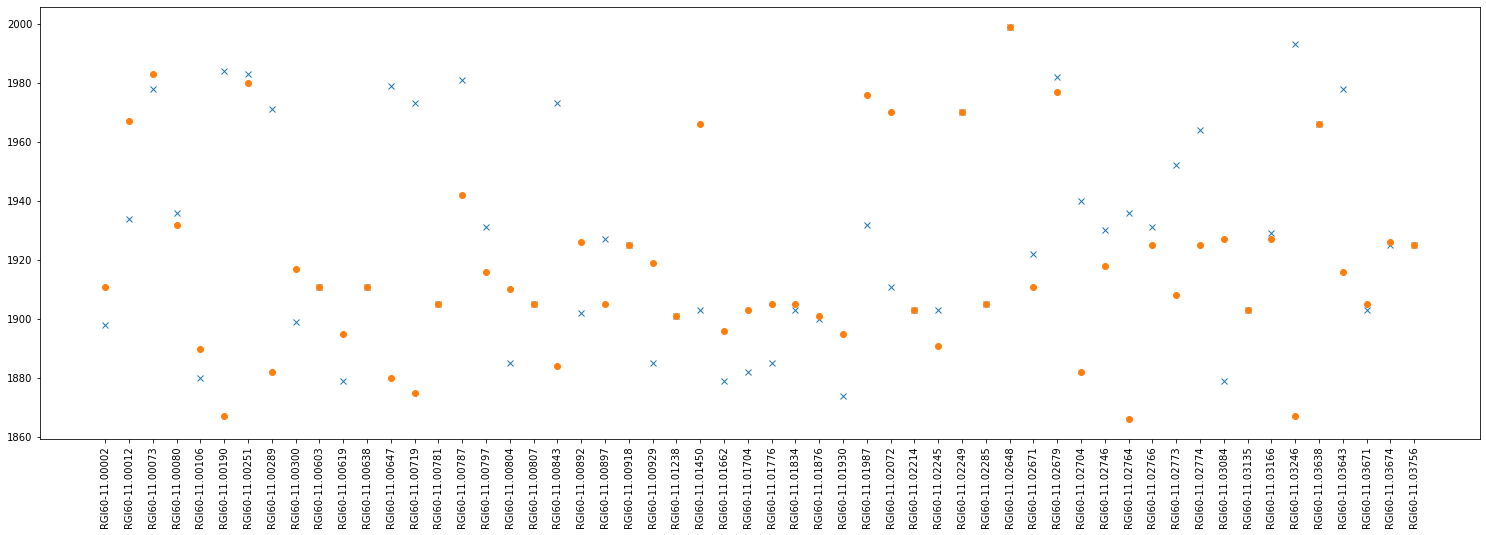

In [84]:
fig = plt.figure(figsize=[20,6])
ax = fig.add_axes([0,0,1,1])

ax.plot(ref_df_oggm.tstar, ls='', marker='x', label='Flowline')
ax.plot(ref_df_vas.tstar, ls='', marker='o', label='V/A scaling')
plt.xticks(rotation=90);

In [82]:
l

<a list of 56 Text xticklabel objects>

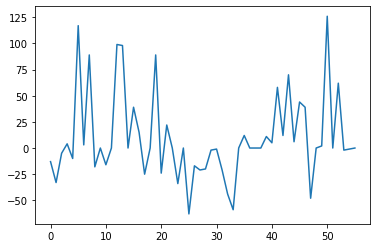

In [43]:
plt.plot(tstars_oggm-tstars_vas)

In [ ]:
rgi_ids = ['RGI60-11.00747']
tstar = 1927
kwargs = dict()

In [ ]:
# compute RGI region and version from RGI IDs
# assuming all they are all the same
rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
rgi_version = (rgi_ids[0].split('-')[0])[-2:]

# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_notebook_wdir'
if not os.path.exists(wdir):
    os.makedirs(wdir)
# shutil.rmtree(wdir)
# os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False

# read RGI entry for the glaciers as DataFrame
# containing the outline area as shapefile
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

# sort by area for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(8, 6))

for ax, border in zip(np.array(axs).flatten(), [10, 80, 160, 250]):
    cfg.PARAMS['border'] = border
    gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)
    graphics.plot_domain(gdirs[0], ax=ax, title='Border: {}'.format(border),
                         add_colorbar=False,
                         lonlat_contours_kwargs={'add_tick_labels':False})

plt.tight_layout(); plt.show()

In [ ]:
# set border parameter
cfg.PARAMS['border'] = 40

# initialize the GlacierDirectory
gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)

# run gis tasks
workflow.gis_prepro_tasks(gdirs)
# run climate tasks
workflow.execute_entity_task(climate.process_histalp_data, gdirs)
workflow.execute_entity_task(climate.local_t_star, gdirs,
                             tstar=tstar, bias=0)
workflow.execute_entity_task(climate.mu_star_calibration, gdirs)
# run inversion tasks
workflow.inversion_tasks(gdirs)
# finalize preprocessing
workflow.execute_entity_task(flowline.init_present_time_glacier, gdirs)

# use t* as center year, even if specified differently
kwargs['y0'] = tstar
# run for 3000 years if not specified otherwise
kwargs.setdefault('nyears', 3000)

In [ ]:
kwargs['nyears'] = 1e3
model = workflow.execute_entity_task(flowline.run_random_climate, gdirs, 
                             temperature_bias=0, output_filesuffix='_test',
                             **kwargs)

In [ ]:
m = model[0]
m.fls[0].rgi_id

In [ ]:
for i in model:
    print(i)

In [ ]:
ds = utils.compile_run_output(gdirs, filesuffix='_test')

In [ ]:
graphics.plot_modeloutput_map(gdirs[0], model=model, filesuffix='_test')

In [ ]:
ds.volume.plot()

In [120]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgi_ids = [rgi_id for rgi_id in rgidf.sort_values('Area', ascending=False).RGIId]

In [121]:
rgi_ids

['RGI60-11.00719',
 'RGI60-11.00897',
 'RGI60-11.00945',
 'RGI60-11.00958',
 'RGI60-11.00787',
 'RGI60-11.00943',
 'RGI60-11.00957',
 'RGI60-11.00886',
 'RGI60-11.00779',
 'RGI60-11.00720',
 'RGI60-11.00782',
 'RGI60-11.00844',
 'RGI60-11.00674',
 'RGI60-11.00885',
 'RGI60-11.00834',
 'RGI60-11.00919',
 'RGI60-11.00822',
 'RGI60-11.00962',
 'RGI60-11.00860',
 'RGI60-11.00904',
 'RGI60-11.00731',
 'RGI60-11.00944',
 'RGI60-11.00862',
 'RGI60-11.00937',
 'RGI60-11.00739',
 'RGI60-11.00745',
 'RGI60-11.00959',
 'RGI60-11.00895',
 'RGI60-11.00726',
 'RGI60-11.00888',
 'RGI60-11.00702',
 'RGI60-11.00718',
 'RGI60-11.00762',
 'RGI60-11.00753',
 'RGI60-11.00927',
 'RGI60-11.00935',
 'RGI60-11.00839',
 'RGI60-11.00898',
 'RGI60-11.00831',
 'RGI60-11.00814',
 'RGI60-11.00902',
 'RGI60-11.00802',
 'RGI60-11.00729',
 'RGI60-11.00984',
 'RGI60-11.00980',
 'RGI60-11.00737',
 'RGI60-11.00675',
 'RGI60-11.00947',
 'RGI60-11.00724',
 'RGI60-11.00757',
 'RGI60-11.00690',
 'RGI60-11.00873',
 'RGI60-11.0

In [ ]:
nc_new = utils.ncDataset(gdirs[0].get_filepath('gridded_data'))
nc_new

In [ ]:
nc = utils.ncDataset(gdirs[0].get_filepath('gridded_data'))
nc

In [ ]:
graphics.plot_centerlines(gdirs, add_downstream=True, use_flowlines=True)
graphics.plot_googlemap(gdirs)

In [ ]:
graphics.plot_domain(gdirs)

In [ ]:
graphics.plot_centerlines(gdirs, add_downstream=True, use_flowlines=True)
graphics.plot_googlemap(gdirs)

In [ ]:
rgidf

In [ ]:
# test t_star with reference dataframe
ref_df = pd.read_csv(utils.get_demo_file('oggm_ref_tstars_rgi6_histalp.csv'), index_col=0)
kwargs.setdefault('ref_df', ref_df)
vascaling.local_t_star(gdirs[0], **kwargs)

In [ ]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgidf = rgidf.sort_values('Area', ascending=False)
rgi_ids = [rgi_id for rgi_id in rgidf.RGIId]

In [ ]:
rgi_ids[]

In [ ]:
model

In [ ]:
ds = utils.compile_run_output(np.atleast_1d(gdirs), filesuffix='_test', path=False)

In [ ]:
model = flowline.FileModel(gdirs[0].get_filepath('model_run', filesuffix='_test'))

In [ ]:
graphics.plot_modeloutput_map(gdirs[0], model=model)

In [ ]:
graphics.plot_distributed_thickness(gdirs)

In [ ]:
ds.area.plot()

In [ ]:
# define RGI IDs
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgidf = rgidf.sort_values('Area', ascending=False)
rgi_ids = [rgi_id for rgi_id in rgidf.RGIId]
rgi_ids

In [ ]:
rgi_ids

In [ ]:
# load dataset
path = '/Users/oberrauch/work/master/data/eq_runs/rofental_vas.nc'
ds = xr.open_dataset(path)

In [ ]:
ds.sel(normalized=True).volume.plot.line(x='time')

In [ ]:
ds.close()

In [ ]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import the needed OGGM modules
from oggm import cfg, utils, workflow, graphics
from oggm.core import gis, climate, flowline, vascaling

In [ ]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_wdir'
cfg.PATHS['working_dir'] = wdir

In [ ]:
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = '6'
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region='11')
cfg.set_intersects_db(intersects_db)

In [ ]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgidf

In [ ]:
workflow.init_glacier_regions(rgidf)

In [ ]:
ds_ = utils.compile_run_output()

In [ ]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_notebook_wdir'